In [2]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("final_data.csv")
data.describe()
print(f"starting amount of rows: {len(data)}") # starting wtih 173580 rows
print(f"starting number of tasks: {len(data.task_id.unique())}")
print(f"column names: {data.columns}")

starting amount of rows: 173580
starting number of tasks: 60
column names: Index(['Unnamed: 0', 'index_n', 'frames_dropped', 'calculcated_fps',
       'calculated_latency', 'image_size', 'fps', 'cpu', 'memory', 'task_id'],
      dtype='object')


In [3]:
## Cleaning the data - There's some outliers we probably want to get rid of 
data_remove_first = data[data['index_n'] != 0.0]
print(f"new amount of rows: {len(data_remove_first)}")

new amount of rows: 173520


In [4]:
## Want to remove any data where the latency == 0.0 -- this signals to me that there was an issue decoding the data
    # Could be good to analyze that later but not good for general summary statistics
data_remove_decoding_issues = data_remove_first[data['calculated_latency'] != 0.0]
print(len(data_remove_decoding_issues))
## So it appears close to half the total rows had issues decoding the data, this is a bit of a bummer but can dig into that later

82847


<ipython-input-4-d8dbdf7bdbe7>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_remove_decoding_issues = data_remove_first[data['calculated_latency'] != 0.0]


In [5]:
cleaned_data = data_remove_decoding_issues
cleaned_data.describe()
# This doesn't tell us too much besides that the latency averaged around ~7 seconds
# First item to explore is how does image size affect latency and FPS?

,Unnamed: 0,index_n,frames_dropped,calculcated_fps,calculated_latency,image_size,fps,cpu,memory
count,82847.000000,82847.000000,82847.000000,82847.000000,82847.000000,82847.000000,82847.000000,82847.000000,82847.000000
mean,1475.032638,1475.032638,69.082369,26.634808,8.534242,2.023767,22.784651,1076.691250,2.485606
std,935.479743,935.479743,42.148665,16.682015,6.225920,0.999724,6.331604,561.249618,1.012026
min,1.000000,1.000000,0.000000,0.100000,3.393952,1.000000,15.000000,512.000000,1.000000
25%,691.000000,691.000000,38.000000,17.900000,5.749366,1.000000,15.000000,512.000000,2.000000
50%,1384.000000,1384.000000,66.000000,21.300000,7.231173,3.000000,25.000000,1024.000000,2.000000
75%,2166.000000,2166.000000,91.000000,36.000000,8.964213,3.000000,30.000000,1024.000000,3.000000
max,3925.000000,3925.000000,466.000000,385.500000,113.289536,3.000000,30.000000,2048.000000,4.000000


In [6]:
by_image_size = cleaned_data.groupby("image_size").mean()
by_image_size
# It appears only image sizes 1 and 3 worked properly.. This is unfortunate but still enough to draw some conclusions from hopefully
# At first glance the FPS seems much higher for image size 1 than 3 and the latency is lower 

,Unnamed: 0,index_n,frames_dropped,calculcated_fps,calculated_latency,fps,cpu,memory
image_size,,,,,,,,
1,1388.445881,1388.445881,51.471055,36.047882,6.260844,22.789881,1008.274982,2.352951
3,1557.599179,1557.599179,85.875990,17.658781,10.702086,22.779664,1141.930956,2.612101


In [150]:
by_task = cleaned_data.groupby("task_id").median()
row_count = cleaned_data.groupby('task_id').count()['index_n']
result_tasks = by_task[['frames_dropped', 'calculcated_fps','calculated_latency', 'fps', 'cpu', 'memory', 'image_size']]
image_color = by_task['image_size'].apply(lambda image_size: 'red' if image_size > 2 else 'blue')
by_task = result_tasks.join(row_count)
by_task['frame_drop_%'] = by_task['frames_dropped'] / by_task['calculcated_fps']
by_task['hours_lasted'] = ((by_task['index_n'] * 10) / 60) / 60
by_task
# now we have it organized by task id with the relevant parameters
# First question we can answer is - does image size affect 

,frames_dropped,calculcated_fps,calculated_latency,fps,cpu,memory,image_size,index_n,frame_drop_%,hours_lasted
task_id,,,,,,,,,,
task_15,23.0,18.0,6.516591,15.0,512.0,1.0,1.0,3533,1.277778,9.813889
task_16,24.0,18.0,6.494452,15.0,512.0,2.0,1.0,3535,1.333333,9.819444
task_17,37.0,36.1,5.080938,15.0,1024.0,2.0,1.0,3472,1.024931,9.644444
task_18,57.0,45.1,4.825086,15.0,1024.0,3.0,1.0,2078,1.263858,5.772222
task_19,46.0,44.9,4.961200,15.0,2048.0,4.0,1.0,2688,1.024499,7.466667
task_20,33.0,30.0,7.007455,25.0,512.0,1.0,1.0,2401,1.100000,6.669444
task_21,33.0,30.0,6.888262,25.0,512.0,2.0,1.0,2389,1.100000,6.636111
task_22,48.0,45.0,5.565107,25.0,1024.0,2.0,1.0,2675,1.066667,7.430556
task_23,50.0,45.0,5.651782,25.0,1024.0,3.0,1.0,2407,1.111111,6.686111


In [31]:
image_color = by_task['image_size'].apply(lambda x: 'red' if x > 2 else 'blue')

Text(0.5, 1.0, 'Latency measured over differnt amounts of memory allocation')

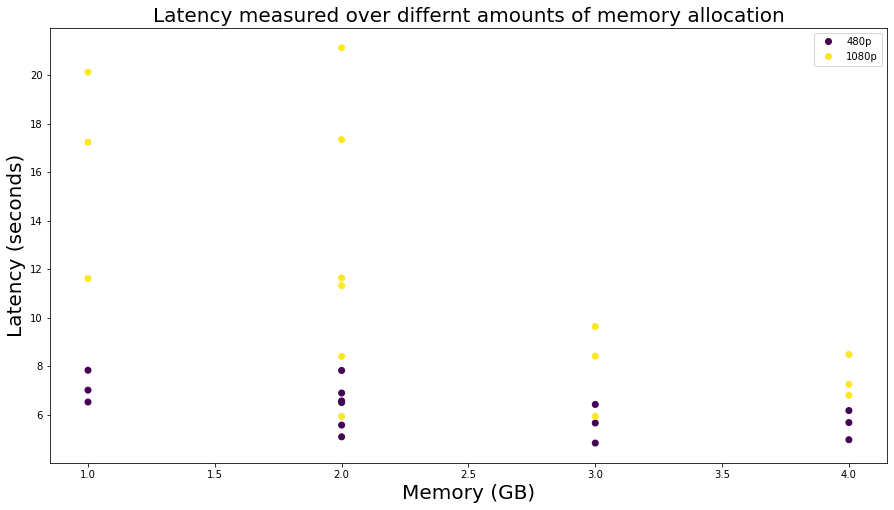

In [133]:
plot = plt.scatter( by_task['memory'], by_task['calculated_latency'], c=by_task['image_size'])
plt.xlabel('Memory (GB)', fontsize=20)
plt.ylabel("Latency (seconds)",fontsize=20)
plt.legend(handles=plot.legend_elements()[0], labels=["480p", "1080p"])
plt.rcParams["figure.figsize"] = (15,8)
plt.title("Latency measured over differnt amounts of memory allocation", fontsize=20)
# So it looks like there is clearly a relationship both with memory allocated to the server and image size

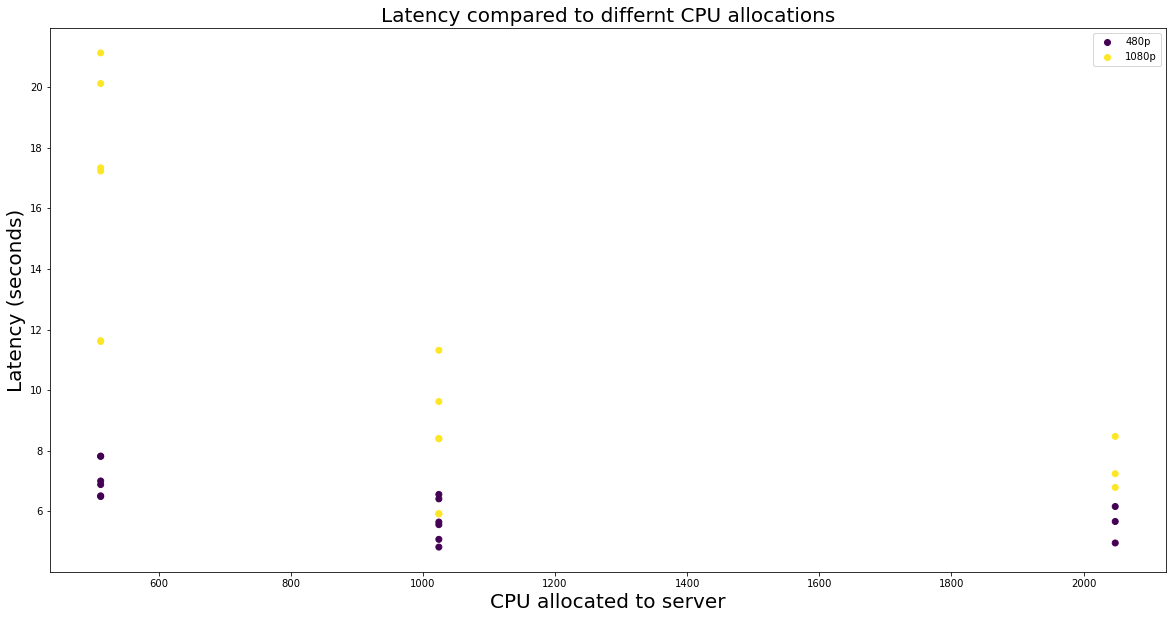

In [136]:
plot = plt.scatter(by_task['cpu'], by_task['calculated_latency'], c=by_task['image_size'])
plt.xlabel('CPU allocated to server', fontsize=20)
plt.ylabel("Latency (seconds)", fontsize=20)
plt.legend(handles=plot.legend_elements()[0], labels=["480p", "1080p"])
plt.title("Latency compared to differnt CPU allocations", fontsize=20)
plt.rcParams["figure.figsize"] = (20,10)
# Also seems to be a relationship between CPU allocation and latency to server, low cpu and high image size causing the most issues

<BarContainer object of 5 artists>

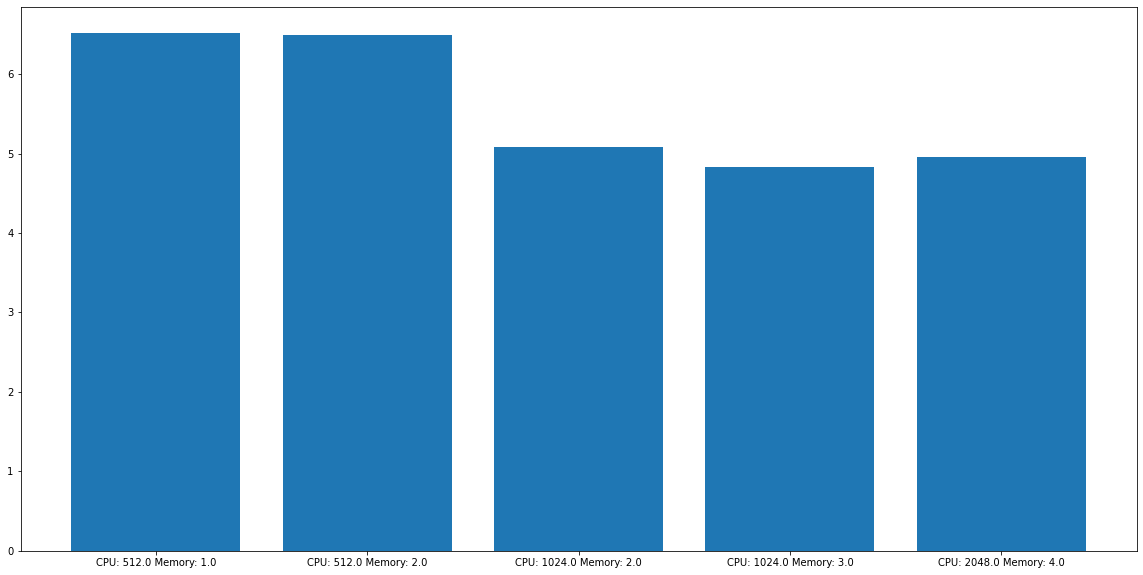

In [80]:
# Now lets take a look at FPS and image groups specifically 
by_task_15_1 = by_task[by_task['image_size'] == 1.0]
by_task_15_1 = by_task_15_1[by_task_15_1['fps'] == 15.0]
memory_cpu_combos = "CPU: " + by_task_15_1['cpu'].apply(lambda x: str(x)) + " Memory: " + by_task_15_1['memory'].apply(lambda x: str(x)) 
plt.bar( memory_cpu_combos, by_task_15_1['calculated_latency'])

task_id
task_15     CPU: 512.0 Memory: 1.0
task_16     CPU: 512.0 Memory: 2.0
task_17    CPU: 1024.0 Memory: 2.0
task_18    CPU: 1024.0 Memory: 3.0
task_19    CPU: 2048.0 Memory: 4.0
dtype: object
task_id
task_45     CPU: 512.0 Memory: 1.0
task_46     CPU: 512.0 Memory: 2.0
task_47    CPU: 1024.0 Memory: 2.0
task_48    CPU: 1024.0 Memory: 3.0
task_49    CPU: 2048.0 Memory: 4.0
dtype: object
task_id
task_20     CPU: 512.0 Memory: 1.0
task_21     CPU: 512.0 Memory: 2.0
task_22    CPU: 1024.0 Memory: 2.0
task_23    CPU: 1024.0 Memory: 3.0
task_24    CPU: 2048.0 Memory: 4.0
dtype: object
task_id
task_50     CPU: 512.0 Memory: 1.0
task_51     CPU: 512.0 Memory: 2.0
task_52    CPU: 1024.0 Memory: 2.0
task_53    CPU: 1024.0 Memory: 3.0
task_54    CPU: 2048.0 Memory: 4.0
dtype: object
task_id
task_25     CPU: 512.0 Memory: 1.0
task_26     CPU: 512.0 Memory: 2.0
task_27    CPU: 1024.0 Memory: 2.0
task_28    CPU: 1024.0 Memory: 3.0
task_29    CPU: 2048.0 Memory: 4.0
dtype: object
task_id
task_55

Text(0.5, 0.98, 'Latency, grouped by FPS and Image Size parameter')

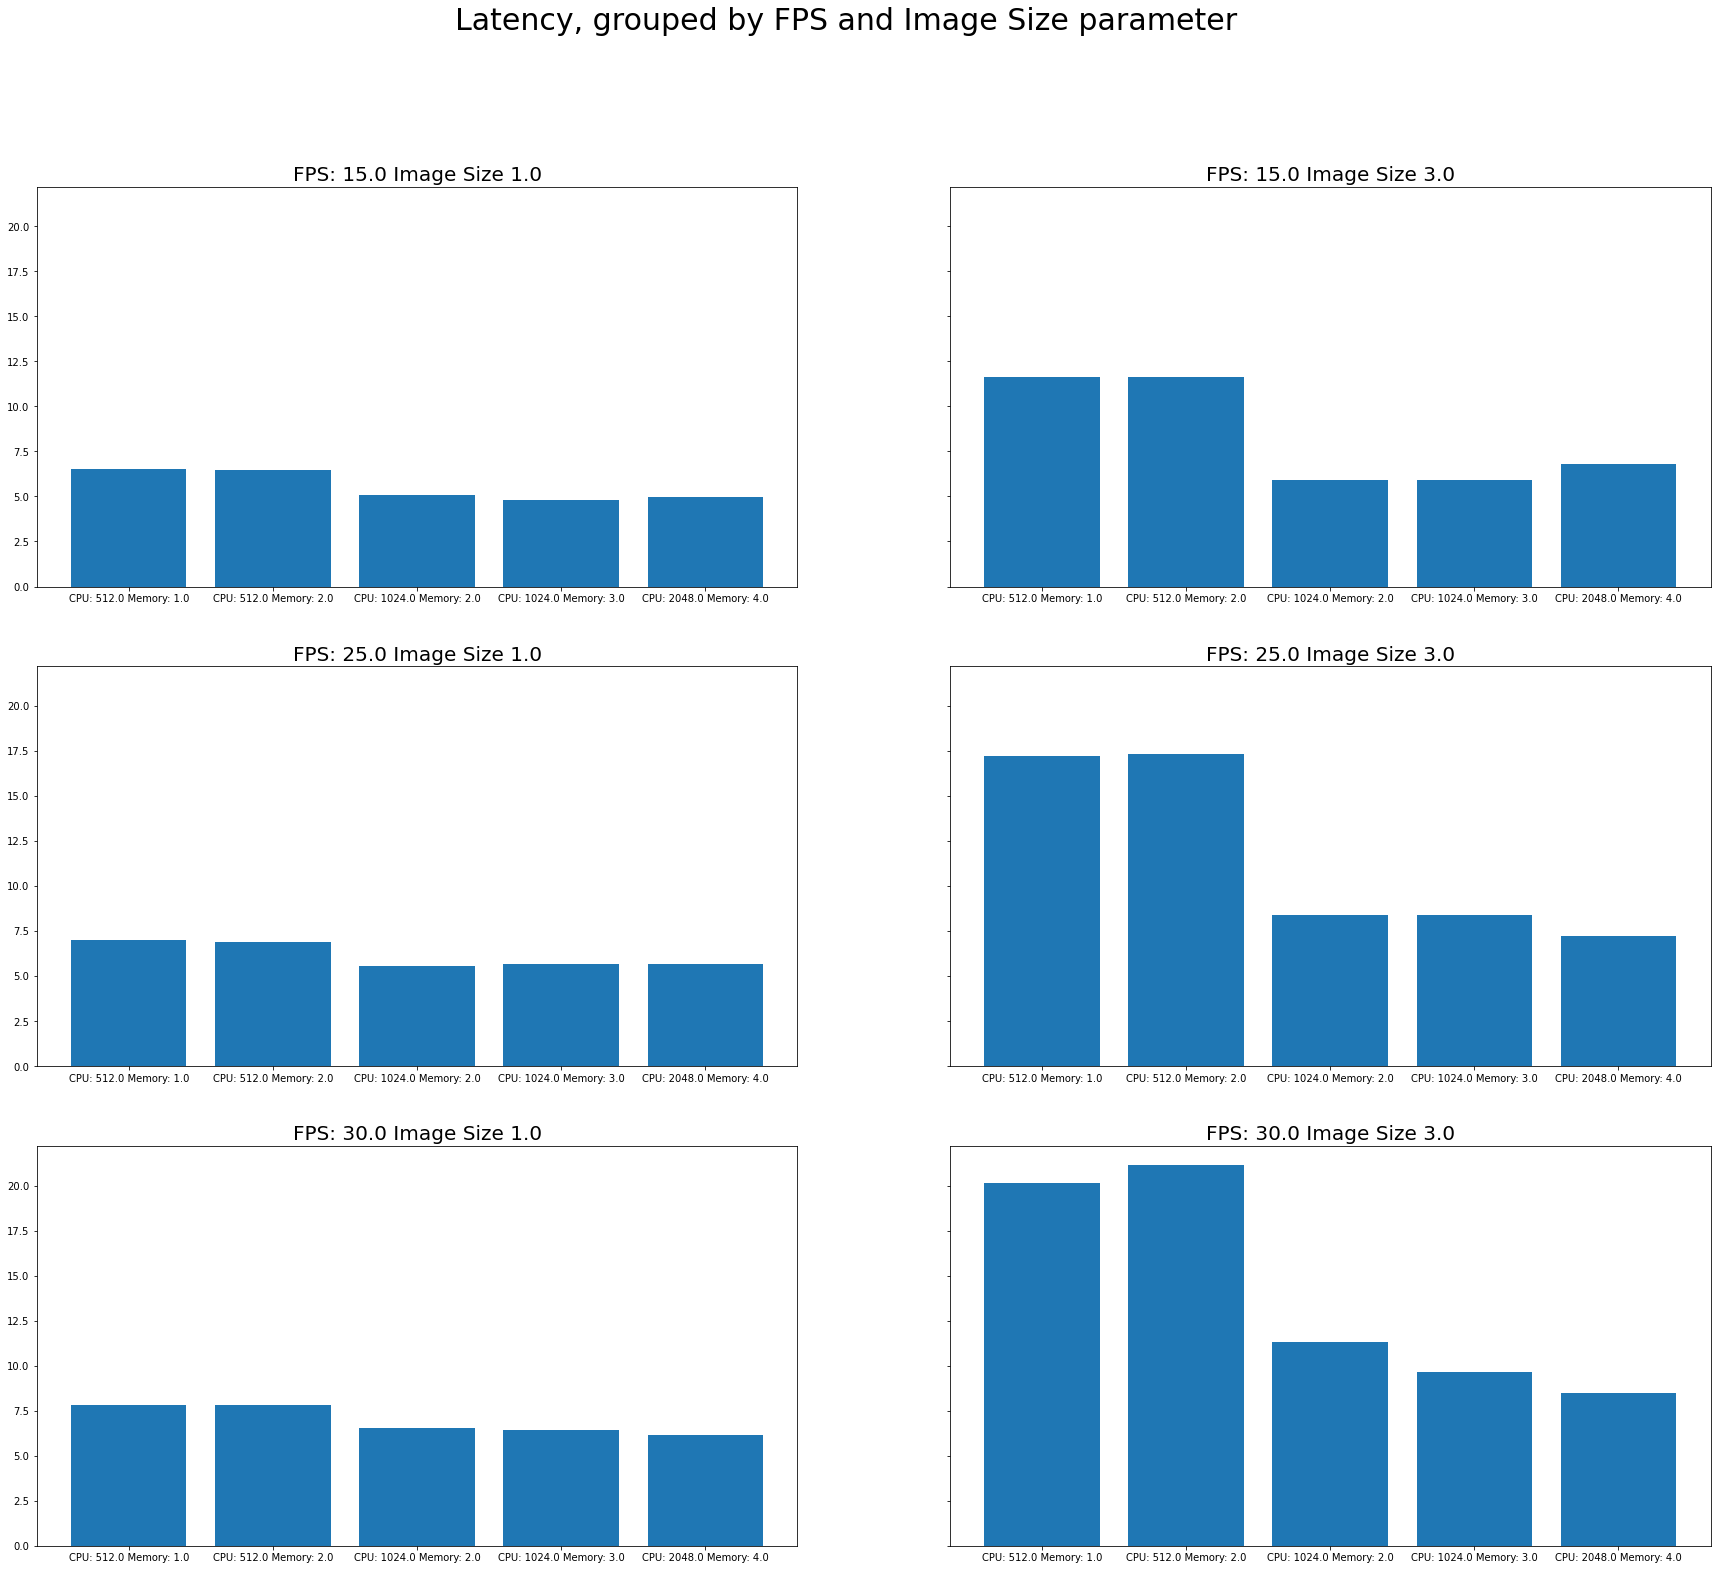

In [142]:
figure, axis = plt.subplots(3, 2, sharey=True)
figure.set_size_inches(30,25, forward=True)
count_row = 0
fps_groups = [15.0, 25.0, 30.0]
image_size_groups = [1.0, 3.0]
count = 0
count_row = 0
for fps in fps_groups:
    for image_size in image_size_groups:
        filtered_dataset = by_task[by_task['image_size'] == image_size]
        filtered_dataset = filtered_dataset[filtered_dataset['fps'] == fps]
        memory_cpu_combos = "CPU: " + filtered_dataset['cpu'].apply(lambda x: str(x)) + " Memory: " + filtered_dataset['memory'].apply(lambda x: str(x)) 
        print(memory_cpu_combos)
        if count % 2 == 0:
            col_number = 0
        else:
            col_number = 1
        count += 1
        axis[count_row, col_number].bar(memory_cpu_combos, filtered_dataset['calculated_latency'])
        axis[count_row, col_number].set_title(f"FPS: {fps} Image Size {image_size}", fontsize=20)
    count_row += 1
figure.suptitle("Latency, grouped by FPS and Image Size parameter", fontsize=30)

Text(0.5, 0.98, 'Frames dropped per FPS, grouped by FPS and Image Size parameter')

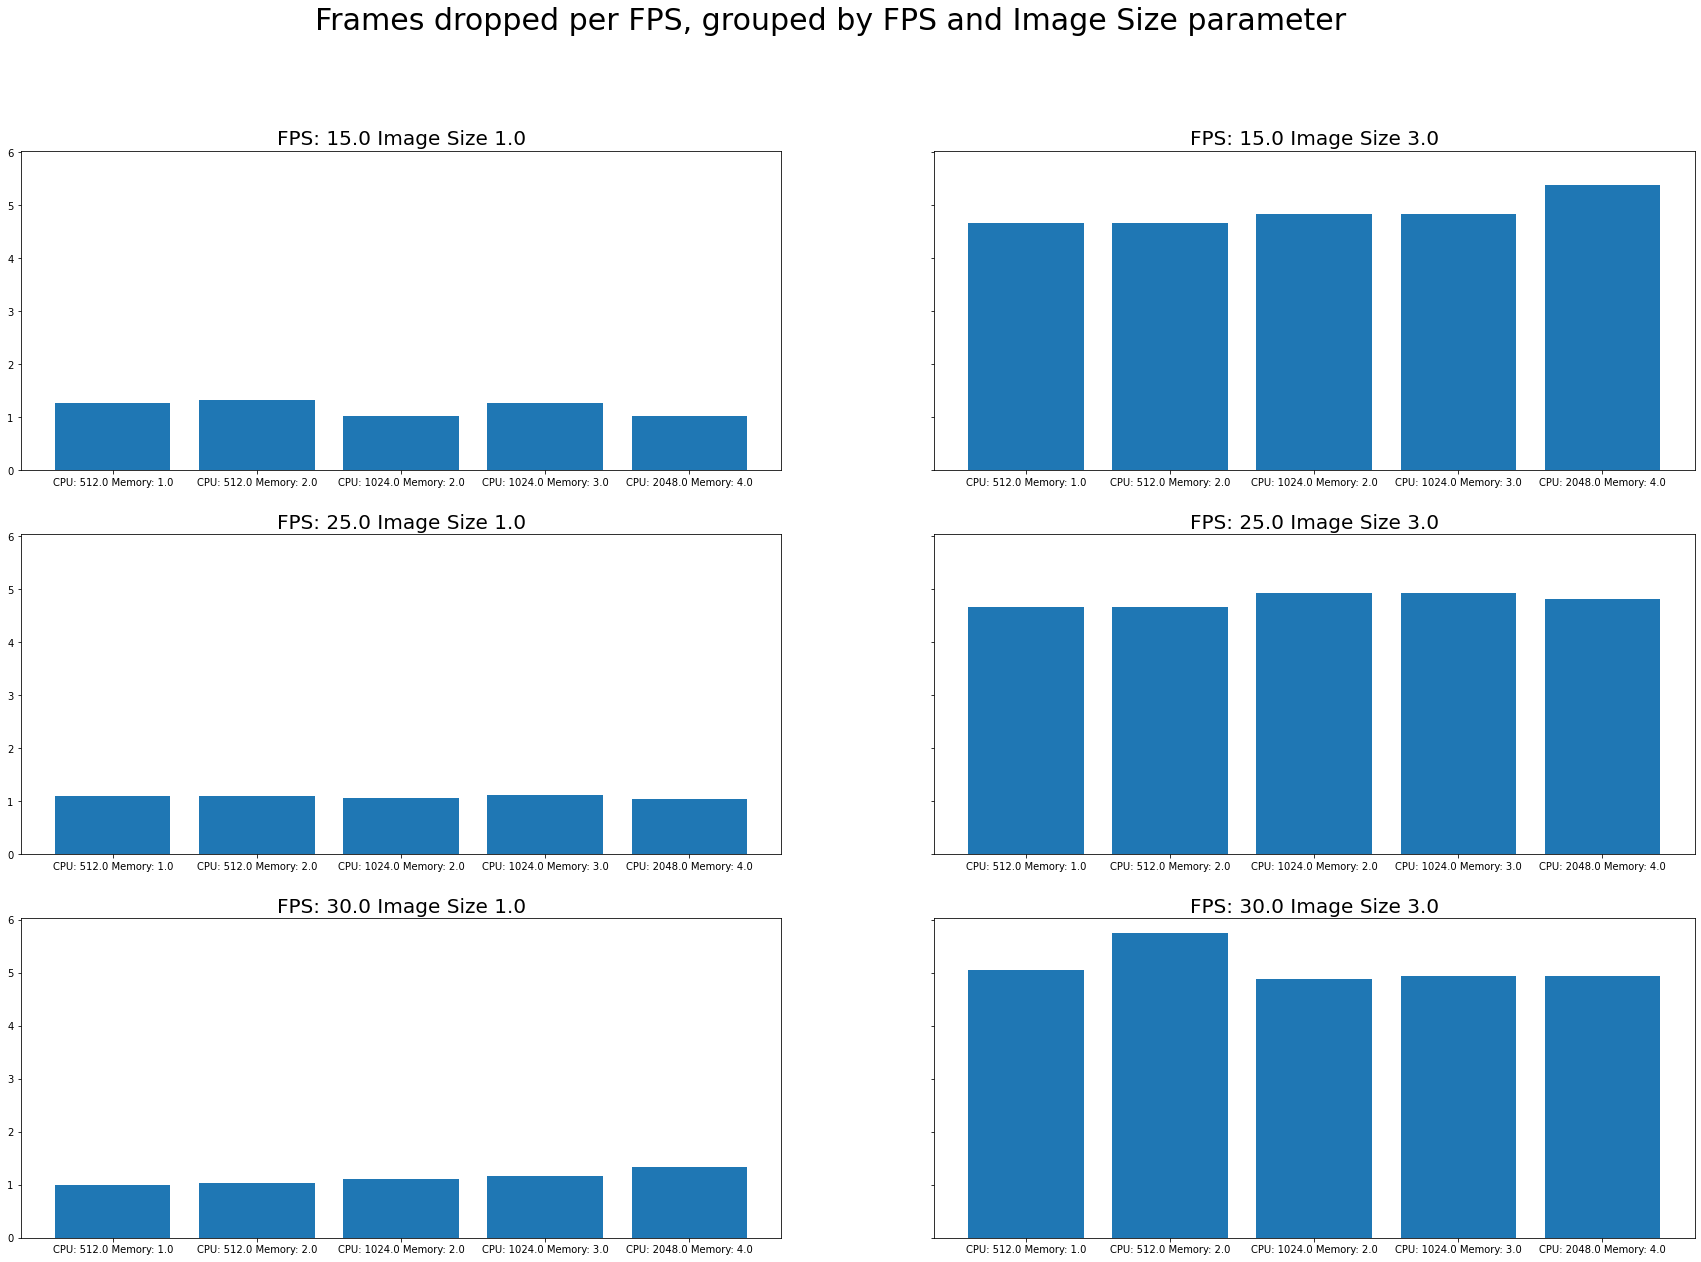

In [148]:
figure, axis = plt.subplots(3, 2, sharey=True)
figure.set_size_inches(30,20, forward=True)
count_row = 0
fps_groups = [15.0, 25.0, 30.0]
image_size_groups = [1.0, 3.0]
count = 0
count_row = 0
for fps in fps_groups:
    for image_size in image_size_groups:
        filtered_dataset = by_task[by_task['image_size'] == image_size]
        filtered_dataset = filtered_dataset[filtered_dataset['fps'] == fps]
        memory_cpu_combos = "CPU: " + filtered_dataset['cpu'].apply(lambda x: str(x)) + " Memory: " + filtered_dataset['memory'].apply(lambda x: str(x)) 
        if count % 2 == 0:
            col_number = 0
        else:
            col_number = 1
        count += 1
        axis[count_row, col_number].bar(memory_cpu_combos, filtered_dataset['frame_drop_%'])
        axis[count_row, col_number].set_title(f"FPS: {fps} Image Size {image_size}", fontsize=20)
    count_row += 1
figure.suptitle("Frames dropped per FPS, grouped by FPS and Image Size parameter", fontsize=30)

Text(0.5, 0.98, 'Calculated FPS, grouped by FPS and Image Size parameter')

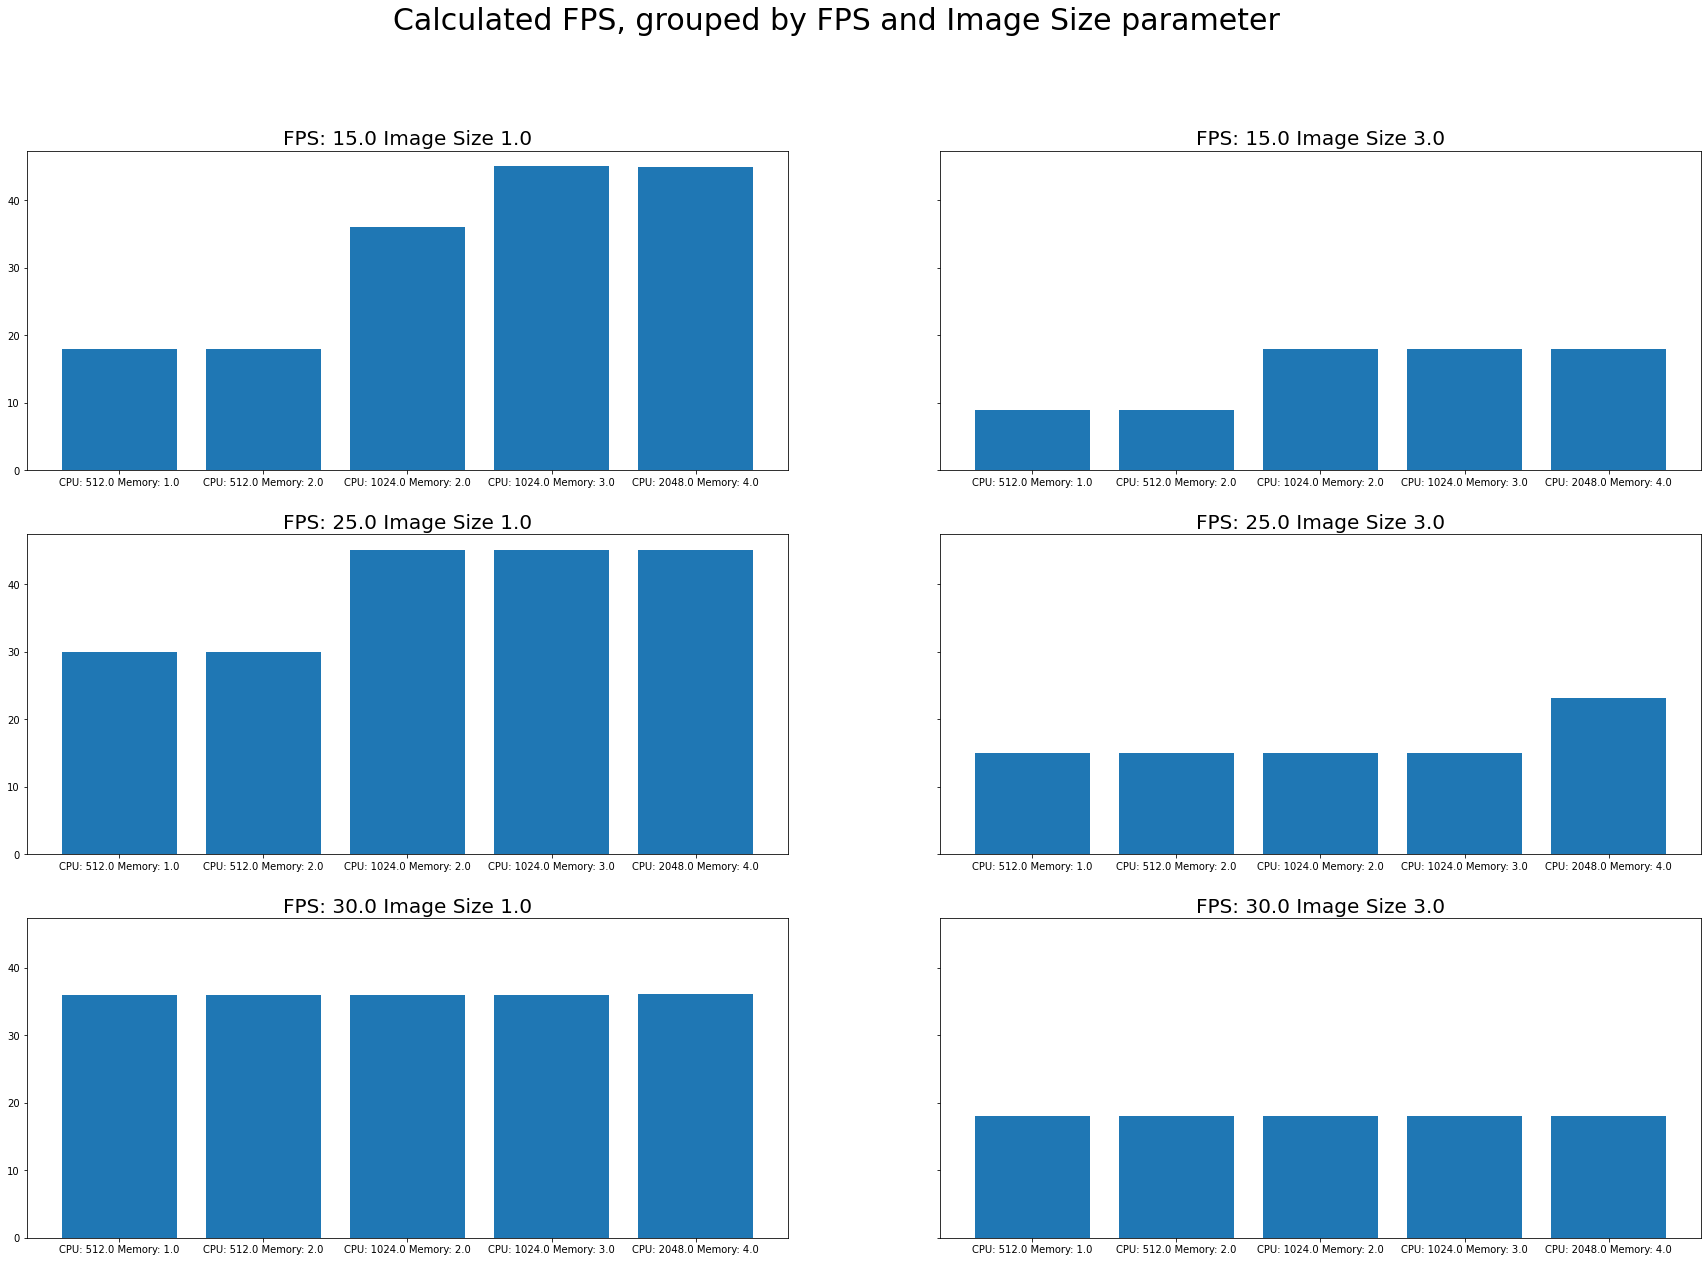

In [149]:
figure, axis = plt.subplots(3, 2, sharey=True)
figure.set_size_inches(30,20, forward=True)
count_row = 0
fps_groups = [15.0, 25.0, 30.0]
image_size_groups = [1.0, 3.0]
count = 0
count_row = 0
for fps in fps_groups:
    for image_size in image_size_groups:
        filtered_dataset = by_task[by_task['image_size'] == image_size]
        filtered_dataset = filtered_dataset[filtered_dataset['fps'] == fps]
        memory_cpu_combos = "CPU: " + filtered_dataset['cpu'].apply(lambda x: str(x)) + " Memory: " + filtered_dataset['memory'].apply(lambda x: str(x)) 
        if count % 2 == 0:
            col_number = 0
        else:
            col_number = 1
        count += 1
        axis[count_row, col_number].bar(memory_cpu_combos, filtered_dataset['calculcated_fps'])
        axis[count_row, col_number].set_title(f"FPS: {fps} Image Size {image_size}", fontsize=20)
    count_row += 1
figure.suptitle("Calculated FPS, grouped by FPS and Image Size parameter", fontsize=30)
# This just shows the calculated FPS stat was most likely flawed ;/

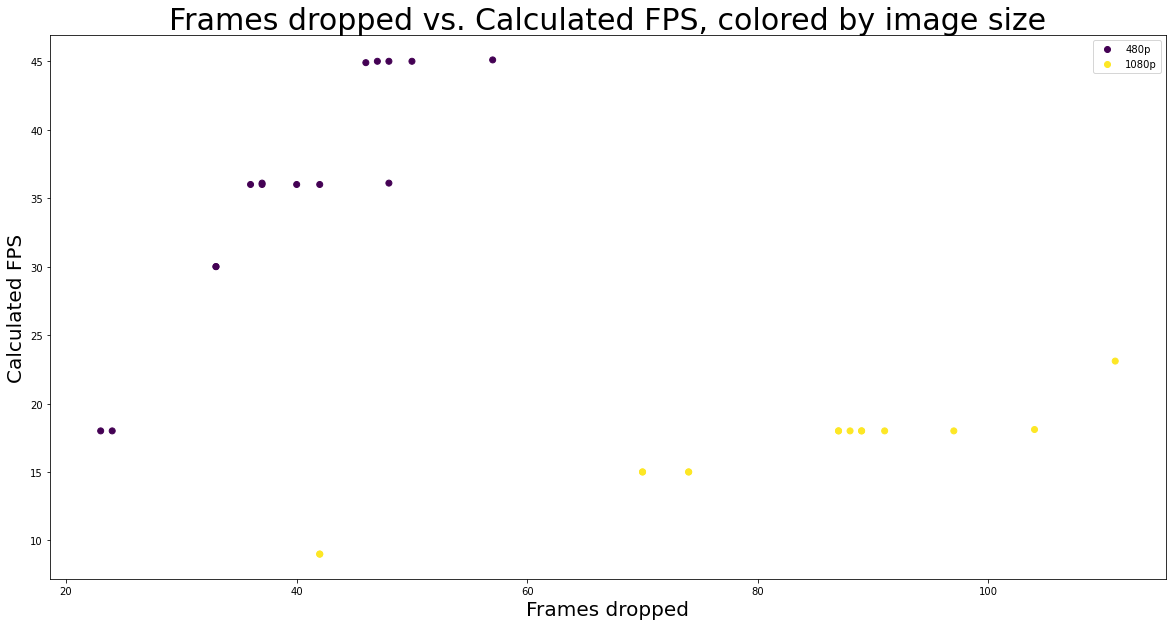

In [120]:
# Now looking at calulated FPS vs Frames dropped
new_plot = plt.scatter(by_task['frames_dropped'], by_task['calculcated_fps'], c=by_task['image_size'])
plt.legend(handles=new_plot.legend_elements()[0], labels=["480p", "1080p"])
plt.title("Frames dropped vs. Calculated FPS, colored by image size", fontsize=30)
plt.xlabel("Frames dropped", fontsize=20)
plt.ylabel("Calculated FPS", fontsize=20)
plt.show()
# SHow trend that more FPS = more frames dropepd, and more frames get dropped with bigger images 

In [126]:
by_task_all = data.groupby("task_id").median()
by_task_all[["fps", "cpu", "memory", "image_size"]]

,fps,cpu,memory,image_size
task_id,,,,
task_0,15.0,512.0,1.0,0.0
task_1,15.0,512.0,2.0,0.0
task_10,30.0,512.0,1.0,0.0
task_11,30.0,512.0,2.0,0.0
task_12,30.0,1024.0,2.0,0.0
task_13,30.0,1024.0,3.0,0.0
task_14,30.0,2048.0,4.0,0.0
task_15,15.0,512.0,1.0,1.0
task_16,15.0,512.0,2.0,1.0


Text(0.5, 0.98, 'Hours server remained operational, grouped by FPS and Image Size parameter')

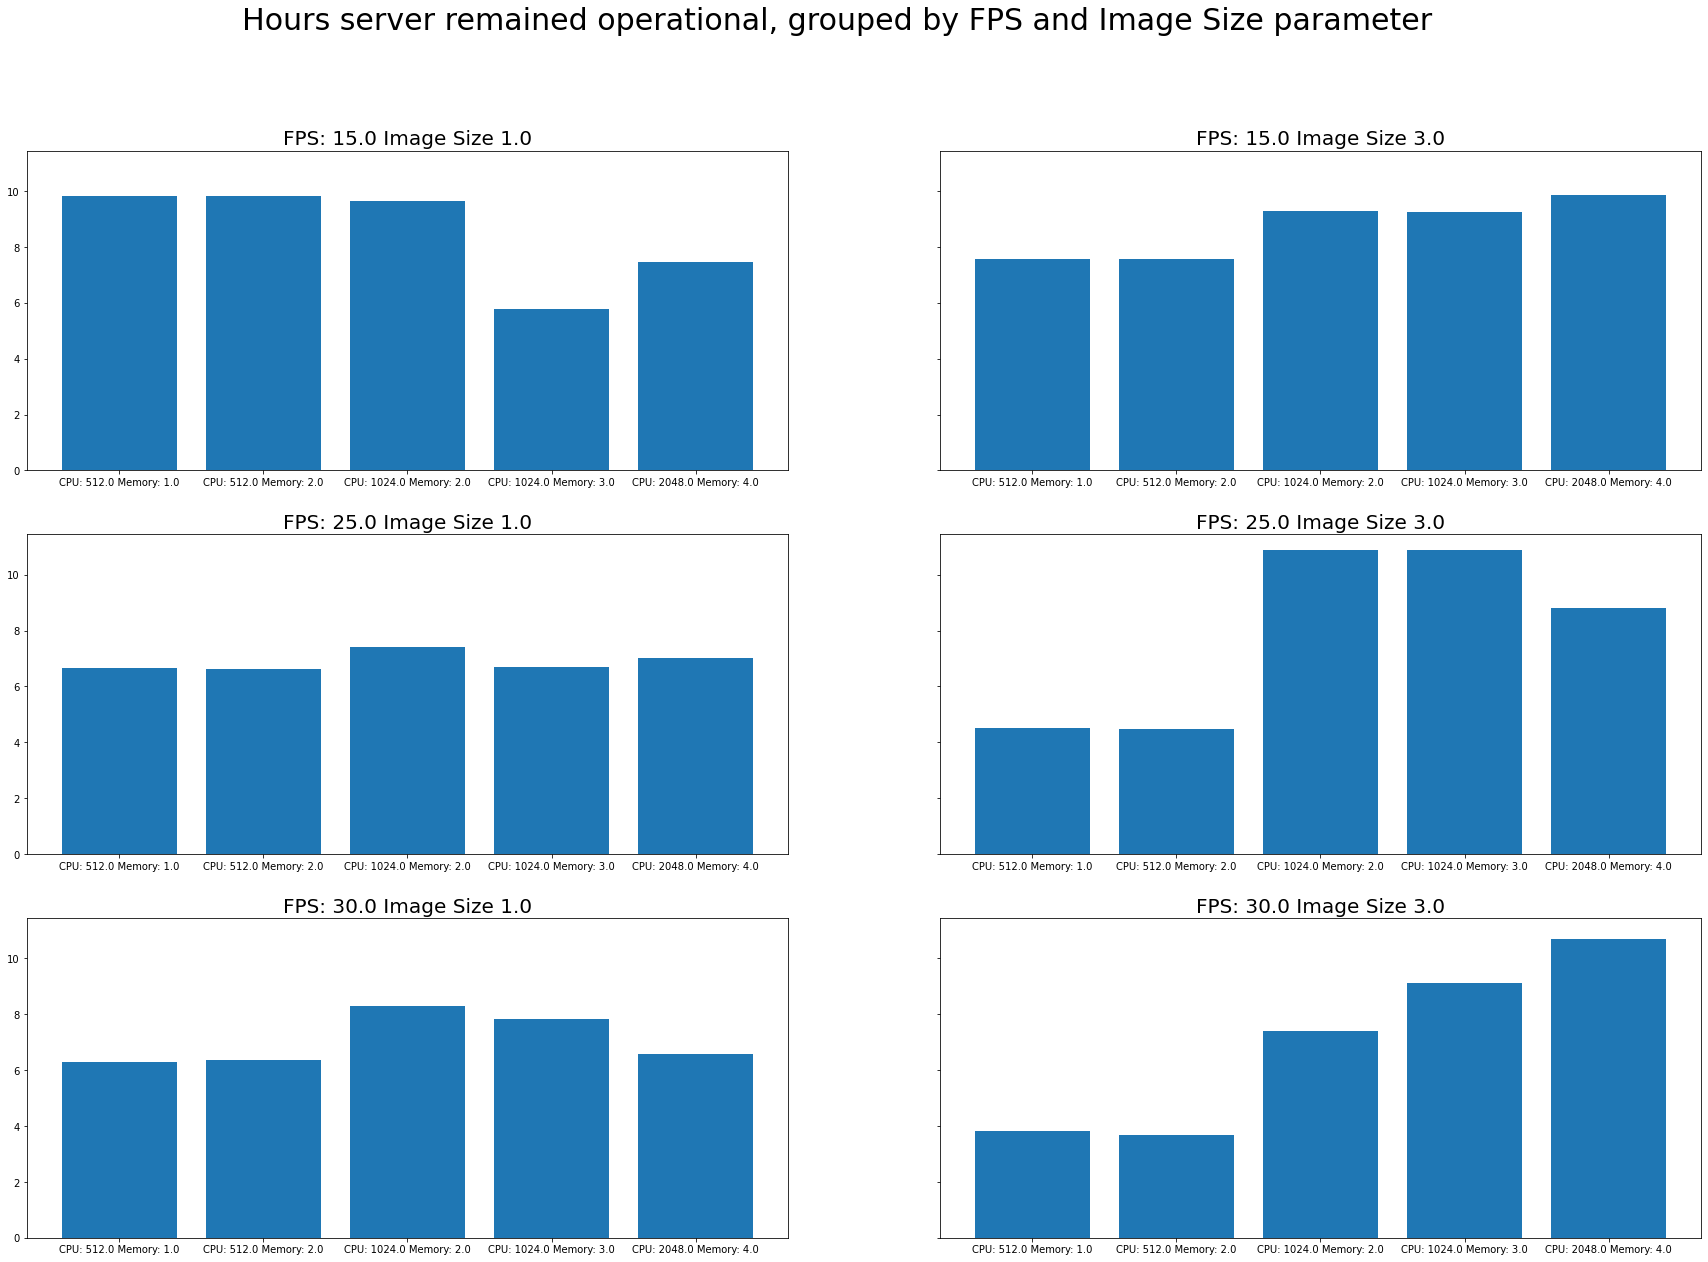

In [154]:
figure, axis = plt.subplots(3, 2, sharey=True)
figure.set_size_inches(30,20, forward=True)
count_row = 0
fps_groups = [15.0, 25.0, 30.0]
image_size_groups = [1.0, 3.0]
count = 0
count_row = 0
for fps in fps_groups:
    for image_size in image_size_groups:
        filtered_dataset = by_task[by_task['image_size'] == image_size]
        filtered_dataset = filtered_dataset[filtered_dataset['fps'] == fps]
        memory_cpu_combos = "CPU: " + filtered_dataset['cpu'].apply(lambda x: str(x)) + " Memory: " + filtered_dataset['memory'].apply(lambda x: str(x)) 
        if count % 2 == 0:
            col_number = 0
        else:
            col_number = 1
        count += 1
        axis[count_row, col_number].bar(memory_cpu_combos, filtered_dataset['hours_lasted'])
        axis[count_row, col_number].set_title(f"FPS: {fps} Image Size {image_size}", fontsize=20)
    count_row += 1
figure.suptitle("Hours server remained operational, grouped by FPS and Image Size parameter", fontsize=30)